In [1]:
import yfinance as yf
yf.pdr_override()
from pandas_datareader import data as pr
from bs4 import BeautifulSoup as bs
from bs4.element import Comment
import pandas as pd
import numpy as np
import requests
import gspread
from oauth2client.service_account import ServiceAccountCredentials
import datetime as dt
import string
import time
import pickle
import seaborn as sns

In [2]:
def get_hyped_days(dataframe):
    if isinstance(dataframe, pd.DataFrame):
        df = dataframe.copy()
        df['Next_day_open'] = df['Open'].shift(-1, axis = 0)
        hype_check = [df['Close'] >= df['Next_day_open']][0]
        day = 0
        while not hype_check[day]:
            day += 1
            if day == df.shape[0]:
                return 0 
                break
        return day
    else:
        print('Variable is not a dataframe')
        return 0

In [3]:
def value_fix(value, replace = False):
    value = value.replace(' ','')
    value = value.split('-')[0]
    letters_pattern = str.maketrans('', '', string.ascii_letters)
    value = value.translate(letters_pattern).strip()
    if replace:
        return float(value.replace(',', '.'))
    else:
        return value.replace(',', '')

In [4]:
def value_fix_dot(value):
    value = value.replace(' ','')
    value = value.split('-')[0]
    letters_pattern = str.maketrans('', '', string.ascii_letters)
    value = value.translate(letters_pattern).strip()
    return float(value.replace('.', ''))


In [5]:
def months(month):
        Months = {
                'Ocak': '1',	
                'Şubat': '2',
                'Mart': '3',	
                'Nisan': '4',	
                'Mayıs': '5',	
                'Haziran': '6',	
                'Temmuz': '7',	
                'Ağustos': '8',	
                'Eylül': '9',	
                'Ekim': '10',	
                'Kasım': '11',	
                'Aralık': '12'
                }       
        if month in Months:
                return Months[month]
        else:
                return month
def fix_time_it(time):
        str_time = ''
        for i in time.split(' '):
                str_time += months(i) + '-'
        #return str_time[:-1]
        return dt.datetime.strptime(str(str_time[:-1]), '%d-%m-%Y').date().strftime('%Y-%m-%d')


In [6]:
def time_it(time):
    """
    Returns time data type of given string in form Y-m-d.
    Example: 2001-01-01."""
    return dt.datetime.strptime(str(time), '%Y-%m-%d')

In [7]:
def g_stocks(stock, time_delta = 999):
    time.sleep(10)
    scope =  ['https://www.googleapis.com/auth/spreadsheets', "https://www.googleapis.com/auth/drive.file", "https://www.googleapis.com/auth/drive"]
    creds = ServiceAccountCredentials.from_json_keyfile_name('cred.json', scope)
    client = gspread.authorize(creds)
    sheet = client.open('stocks').sheet1
    sheet.update_cell(1, 7, stock)
    sheet.update_cell(1, 8, time_delta)
    if not sheet.get_all_records() == []:
        df = pd.DataFrame(sheet.get_all_records())[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']]
        df.drop(df[df['Close'].str.len() == 0].index, inplace = True)
        type_map = {'Open': float,
                    'Close': float,
                    'High': float,
                    'Low': float,
                    'Volume':int}   
        df = df.astype(type_map)
        df['Date'] = pd.to_datetime(df['Date']).dt.strftime('%Y-%m-%d')
        return df.set_index('Date')
    else:
        return pd.DataFrame(columns=['Date', 'Open', 'High', 'Low', 'Close', 'Volume']).set_index('Date')

In [8]:
def page_urls(url):
    page_counter = 1
    pages = [url]
    soup = make_soup(url)
    while soup.find(class_ = 'rightNav'):
        page_counter += 1
        pages.append(url+f'page/{page_counter}/')
        soup = make_soup(pages[-1])
    return pages    


In [9]:

def make_request(url):
    """Request maker.
    Makes request for given url."""
    headers = {'User-Agent': "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/42.0.2311.135 Safari/537.36 Edge/12.246"}
    return requests.get(url=url, headers=headers)

In [10]:
def make_soup(url):
    """Soup maker.
    Returns soup for given url."""
    r = make_request(url)
    if r.status_code == 200:
        return bs(r.content, 'html5lib')
    else:
        return False

In [11]:
def get_halka_arz_info(url, soup = False):
    cols = []
    vals = []
    if not soup:
        soup = make_soup(url)
    info_table = soup.find('table', {'class': 'sp-table'})
    rows = info_table.find_all('tr')
    for row in rows:
        row_data = row.find_all('td')
        cols.append(row_data[0].text)
        vals.append(row_data[1].text)
    return pd.DataFrame(data = [vals], columns = cols)

In [12]:
def get_halka_arz_result(url, soup = False):
    if not soup:
        soup = make_soup(url)
    vals = []
    cols = []
    #cols = ['Yurtiçi_Bireysel_Kisi', 'Yurtiçi_Bireysel_Lot',
    #    'Yurtiçi_Kurumsal_Kisi', 'Yurtiçi_Kurumsal_Lot',
    #    'Yurtdışı_Kurumsal_Kisi', 'Yurtdışı_Kurumsal_Lot',
    #    'Şirket_Çalışanları_Kisi', 'Şirket_Çalışanları_Lot']
    table = soup.find('table', {'class': 'as-table'})
    if not table == None:
        rows = table.find_all('tr')
        for i in range(2, len(rows)-2):
            row_data = rows[i].find_all('td')
            for ex in ['_Kisi', '_Lot']:
                cols.append(row_data[0].text.strip()+ex)
            for j in range(1,3):
                vals.append(row_data[j].text)
        return pd.DataFrame(data = [vals], columns = cols)
    else:
        return pd.DataFrame()

In [13]:
def get_hist_data(stock, time_delta = 999):
    df = pr.DataReader(stock + '.IS')
    df.drop(columns=['Adj Close'], inplace=True)
    if df.shape[0] <= 1:
        df = g_stocks(stock, time_delta=time_delta)
    return df

In [16]:
url = 'https://halkarz.com/k/halka-arz/'

In [17]:
start_year = dt.datetime.today().year
year_period = 3
halka_arz_pages = {}
stocks = {}
for i in range(year_period):
    year_page = url+f'{start_year - i}/'
    #halka_arz_pages.update({page : {'Pages':page_urls(page)}})
    pages = page_urls(year_page)
    for page in pages:
        page_soup = make_soup(page)
        stocks_ = page_soup.find_all(class_ = "halka-arz-list archives")
        for stock in stocks_:
            stock_content = stock.find(class_ = 'il-content')
            stock_symbol = stock_content.find(class_ = 'il-bist-kod').get_text(strip=True)
            stock_name = stock_content.find(class_ = 'il-halka-arz-sirket').find('a')['title']
            stock_page = stock_content.find(class_ = 'il-halka-arz-sirket').find('a')['href']
            stocks.update({stock_symbol :
                            {'url':stock_page,
                             'stock_name':stock_name,
                             'release_year':start_year-i}})

In [18]:
for stock in stocks:
    stocks[stock].update({'Halka_arz_info': get_halka_arz_info(stocks[stock]['url'])})
    stocks[stock].update({'Halka_arz_result': get_halka_arz_result(stocks[stock]['url'])})

In [22]:
for stock in stocks:
    print(stock)
    stocks[stock].update({'Hist_data': get_hist_data(stock, time_delta=1100)})
    

AVPGY
[*********************100%***********************]  1 of 1 completed

ERROR 
1 Failed download:
ERROR ['AVPGY.IS']: Exception('AVPGY.IS: No timezone found, symbol may be delisted')



MEGMT
[*********************100%***********************]  1 of 1 completed
KBORU
[*********************100%***********************]  1 of 1 completed
SURGY
[*********************100%***********************]  1 of 1 completed
CATES
[*********************100%***********************]  1 of 1 completed
SKYMD
[*********************100%***********************]  1 of 1 completed
BEGYO
[*********************100%***********************]  1 of 1 completed
AGROT
[*********************100%***********************]  1 of 1 completed
EKOS
[*********************100%***********************]  1 of 1 completed
BINHO
[*********************100%***********************]  1 of 1 completed
MARBL
[*********************100%***********************]  1 of 1 completed

ERROR 
1 Failed download:
ERROR ['MARBL.IS']: Exception('MARBL.IS: 1d data not available for startTime=-2208994789 and endTime=1702980383. Only 100 years worth of day granularity data are allowed to be fetched per request.')



TABGD
[*********************100%***********************]  1 of 1 completed
VRGYO
[*********************100%***********************]  1 of 1 completed
MHRGY
[*********************100%***********************]  1 of 1 completed
BORLS
[*********************100%***********************]  1 of 1 completed
DOFER
[*********************100%***********************]  1 of 1 completed
MEKAG
[*********************100%***********************]  1 of 1 completed
DMRGD
[*********************100%***********************]  1 of 1 completed
ADGYO
[*********************100%***********************]  1 of 1 completed
HATSN
[*********************100%***********************]  1 of 1 completed
REEDR
[*********************100%***********************]  1 of 1 completed
GIPTA
[*********************100%***********************]  1 of 1 completed
TARKM
[*********************100%***********************]  1 of 1 completed
EBEBK
[*********************100%***********************]  1 of 1 completed
KZGYO
[*****************

ERROR 
1 Failed download:
ERROR ['TATEN.IS']: Exception('TATEN.IS: 1d data not available for startTime=-2208994789 and endTime=1702980400. Only 100 years worth of day granularity data are allowed to be fetched per request.')



OFSYM
[*********************100%***********************]  1 of 1 completed
IZENR
[*********************100%***********************]  1 of 1 completed
ASGYO
[*********************100%***********************]  1 of 1 completed
KLSER
[*********************100%***********************]  1 of 1 completed
FZLGY
[*********************100%***********************]  1 of 1 completed
ATAKP
[*********************100%***********************]  1 of 1 completed
FORTE
[*********************100%***********************]  1 of 1 completed
A1CAP
[*********************100%***********************]  1 of 1 completed
PASEU
[*********************100%***********************]  1 of 1 completed
KTLEV
[*********************100%***********************]  1 of 1 completed
BIENY
[*********************100%***********************]  1 of 1 completed
KAYSE
[*********************100%***********************]  1 of 1 completed
BIGCH
[*********************100%***********************]  1 of 1 completed
CWENE
[*****************

ERROR 
1 Failed download:
ERROR ['CVKMD.IS']: Exception('CVKMD.IS: 1d data not available for startTime=-2208994789 and endTime=1702980418. Only 100 years worth of day granularity data are allowed to be fetched per request.')



KOPOL
[*********************100%***********************]  1 of 1 completed

ERROR 
1 Failed download:
ERROR ['KOPOL.IS']: Exception('KOPOL.IS: 1d data not available for startTime=-2208994789 and endTime=1702980431. Only 100 years worth of day granularity data are allowed to be fetched per request.')



EKSUN
[*********************100%***********************]  1 of 1 completed

ERROR 
1 Failed download:
ERROR ['EKSUN.IS']: Exception('EKSUN.IS: 1d data not available for startTime=-2208994789 and endTime=1702980445. Only 100 years worth of day granularity data are allowed to be fetched per request.')



AKFYE
[*********************100%***********************]  1 of 1 completed
GOKNR
[*********************100%***********************]  1 of 1 completed
BVSAN
[*********************100%***********************]  1 of 1 completed
MACKO
[*********************100%***********************]  1 of 1 completed

ERROR 
1 Failed download:
ERROR ['MACKO.IS']: Exception('MACKO.IS: 1d data not available for startTime=-2208994789 and endTime=1702980459. Only 100 years worth of day granularity data are allowed to be fetched per request.')



ASTOR
[*********************100%***********************]  1 of 1 completed

ERROR 
1 Failed download:
ERROR ['ASTOR.IS']: Exception('ASTOR.IS: 1d data not available for startTime=-2208994789 and endTime=1702980472. Only 100 years worth of day granularity data are allowed to be fetched per request.')



TNZTP
[*********************100%***********************]  1 of 1 completed
SOKE
[*********************100%***********************]  1 of 1 completed

ERROR 
1 Failed download:
ERROR ['SOKE.IS']: Exception('SOKE.IS: 1d data not available for startTime=-2208994789 and endTime=1702980486. Only 100 years worth of day granularity data are allowed to be fetched per request.')



SDTTR
[*********************100%***********************]  1 of 1 completed

ERROR 
1 Failed download:
ERROR ['SDTTR.IS']: Exception('SDTTR.IS: 1d data not available for startTime=-2208994789 and endTime=1702980500. Only 100 years worth of day granularity data are allowed to be fetched per request.')



ONCSM
[*********************100%***********************]  1 of 1 completed

ERROR 
1 Failed download:
ERROR ['ONCSM.IS']: Exception('ONCSM.IS: 1d data not available for startTime=-2208994789 and endTime=1702980513. Only 100 years worth of day granularity data are allowed to be fetched per request.')



EYGYO
[*********************100%***********************]  1 of 1 completed
TERA
[*********************100%***********************]  1 of 1 completed
AHGAZ
[*********************100%***********************]  1 of 1 completed
BRKVY
[*********************100%***********************]  1 of 1 completed

ERROR 
1 Failed download:
ERROR ['BRKVY.IS']: Exception('BRKVY.IS: 1d data not available for startTime=-2208994789 and endTime=1702980527. Only 100 years worth of day granularity data are allowed to be fetched per request.')



PLTUR
[*********************100%***********************]  1 of 1 completed

ERROR 
1 Failed download:
ERROR ['PLTUR.IS']: Exception('PLTUR.IS: 1d data not available for startTime=-2208994789 and endTime=1702980541. Only 100 years worth of day granularity data are allowed to be fetched per request.')



OZSUB
[*********************100%***********************]  1 of 1 completed

ERROR 
1 Failed download:
ERROR ['OZSUB.IS']: Exception('OZSUB.IS: 1d data not available for startTime=-2208994789 and endTime=1702980554. Only 100 years worth of day granularity data are allowed to be fetched per request.')



SNICA
[*********************100%***********************]  1 of 1 completed

ERROR 
1 Failed download:
ERROR ['SNICA.IS']: Exception('SNICA.IS: 1d data not available for startTime=-2208994789 and endTime=1702980568. Only 100 years worth of day granularity data are allowed to be fetched per request.')



ALFAS
[*********************100%***********************]  1 of 1 completed
AZTEK
[*********************100%***********************]  1 of 1 completed

ERROR 
1 Failed download:
ERROR ['AZTEK.IS']: Exception('AZTEK.IS: 1d data not available for startTime=-2208994789 and endTime=1702980581. Only 100 years worth of day granularity data are allowed to be fetched per request.')



HKTM
[*********************100%***********************]  1 of 1 completed

ERROR 
1 Failed download:
ERROR ['HKTM.IS']: Exception('HKTM.IS: 1d data not available for startTime=-2208994789 and endTime=1702980595. Only 100 years worth of day granularity data are allowed to be fetched per request.')



BARMA
[*********************100%***********************]  1 of 1 completed

ERROR 
1 Failed download:
ERROR ['BARMA.IS']: Exception('BARMA.IS: 1d data not available for startTime=-2208994789 and endTime=1702980608. Only 100 years worth of day granularity data are allowed to be fetched per request.')



OBASE
[*********************100%***********************]  1 of 1 completed

ERROR 
1 Failed download:
ERROR ['OBASE.IS']: Exception('OBASE.IS: 1d data not available for startTime=-2208994789 and endTime=1702980622. Only 100 years worth of day granularity data are allowed to be fetched per request.')



KRPLS
[*********************100%***********************]  1 of 1 completed

ERROR 
1 Failed download:
ERROR ['KRPLS.IS']: Exception('KRPLS.IS: 1d data not available for startTime=-2208994789 and endTime=1702980636. Only 100 years worth of day granularity data are allowed to be fetched per request.')



KLRHO
[*********************100%***********************]  1 of 1 completed
RUBNS
[*********************100%***********************]  1 of 1 completed
KCAER
[*********************100%***********************]  1 of 1 completed

ERROR 
1 Failed download:
ERROR ['KCAER.IS']: Exception('KCAER.IS: 1d data not available for startTime=-2208994789 and endTime=1702980650. Only 100 years worth of day granularity data are allowed to be fetched per request.')



PRDGS
[*********************100%***********************]  1 of 1 completed

ERROR 
1 Failed download:
ERROR ['PRDGS.IS']: Exception('PRDGS.IS: 1d data not available for startTime=-2208994789 and endTime=1702980664. Only 100 years worth of day granularity data are allowed to be fetched per request.')



MAKIM
[*********************100%***********************]  1 of 1 completed

ERROR 
1 Failed download:
ERROR ['MAKIM.IS']: Exception('MAKIM.IS: 1d data not available for startTime=-2208994789 and endTime=1702980678. Only 100 years worth of day granularity data are allowed to be fetched per request.')



EUREN
[*********************100%***********************]  1 of 1 completed

ERROR 
1 Failed download:
ERROR ['EUREN.IS']: Exception('EUREN.IS: 1d data not available for startTime=-2208994789 and endTime=1702980692. Only 100 years worth of day granularity data are allowed to be fetched per request.')



SEGYO
[*********************100%***********************]  1 of 1 completed

ERROR 
1 Failed download:
ERROR ['SEGYO.IS']: Exception('SEGYO.IS: 1d data not available for startTime=-2208994789 and endTime=1702980706. Only 100 years worth of day granularity data are allowed to be fetched per request.')



SUNTK
[*********************100%***********************]  1 of 1 completed
YYLGD
[*********************100%***********************]  1 of 1 completed
BMSTL
[*********************100%***********************]  1 of 1 completed

ERROR 
1 Failed download:
ERROR ['BMSTL.IS']: Exception('BMSTL.IS: 1d data not available for startTime=-2208994789 and endTime=1702980721. Only 100 years worth of day granularity data are allowed to be fetched per request.')



IMASM
[*********************100%***********************]  1 of 1 completed

ERROR 
1 Failed download:
ERROR ['IMASM.IS']: Exception('IMASM.IS: 1d data not available for startTime=-2208994789 and endTime=1702980735. Only 100 years worth of day granularity data are allowed to be fetched per request.')



KMPUR
[*********************100%***********************]  1 of 1 completed
CONSE
[*********************100%***********************]  1 of 1 completed

ERROR 
1 Failed download:
ERROR ['CONSE.IS']: Exception('CONSE.IS: 1d data not available for startTime=-2208994789 and endTime=1702980750. Only 100 years worth of day granularity data are allowed to be fetched per request.')



SUWEN
[*********************100%***********************]  1 of 1 completed

ERROR 
1 Failed download:
ERROR ['SUWEN.IS']: Exception('SUWEN.IS: 1d data not available for startTime=-2208994789 and endTime=1702980764. Only 100 years worth of day granularity data are allowed to be fetched per request.')



LIDER
[*********************100%***********************]  1 of 1 completed

ERROR 
1 Failed download:
ERROR ['LIDER.IS']: Exception('LIDER.IS: 1d data not available for startTime=-2208994789 and endTime=1702980778. Only 100 years worth of day granularity data are allowed to be fetched per request.')



SMRTG
[*********************100%***********************]  1 of 1 completed
ENSRI
[*********************100%***********************]  1 of 1 completed

ERROR 
1 Failed download:
ERROR ['ENSRI.IS']: Exception('ENSRI.IS: 1d data not available for startTime=-2208994789 and endTime=1702980792. Only 100 years worth of day granularity data are allowed to be fetched per request.')



GRSEL
[*********************100%***********************]  1 of 1 completed

ERROR 
1 Failed download:
ERROR ['GRSEL.IS']: Exception('GRSEL.IS: 1d data not available for startTime=-2208994789 and endTime=1702980806. Only 100 years worth of day granularity data are allowed to be fetched per request.')



GZNMI
[*********************100%***********************]  1 of 1 completed

ERROR 
1 Failed download:
ERROR ['GZNMI.IS']: Exception('GZNMI.IS: 1d data not available for startTime=-2208994789 and endTime=1702980820. Only 100 years worth of day granularity data are allowed to be fetched per request.')



KLSYN
[*********************100%***********************]  1 of 1 completed

ERROR 
1 Failed download:
ERROR ['KLSYN.IS']: Exception('KLSYN.IS: 1d data not available for startTime=-2208994789 and endTime=1702980834. Only 100 years worth of day granularity data are allowed to be fetched per request.')



HTTBT
[*********************100%***********************]  1 of 1 completed
INVES
[*********************100%***********************]  1 of 1 completed

ERROR 
1 Failed download:
ERROR ['INVES.IS']: Exception('INVES.IS: 1d data not available for startTime=-2208994789 and endTime=1702980848. Only 100 years worth of day granularity data are allowed to be fetched per request.')



DAPGM
[*********************100%***********************]  1 of 1 completed
HUNER
[*********************100%***********************]  1 of 1 completed

ERROR 
1 Failed download:
ERROR ['HUNER.IS']: Exception('HUNER.IS: 1d data not available for startTime=-2208994789 and endTime=1702980862. Only 100 years worth of day granularity data are allowed to be fetched per request.')



PNLSN
[*********************100%***********************]  1 of 1 completed
ERCB
[*********************100%***********************]  1 of 1 completed

ERROR 
1 Failed download:
ERROR ['ERCB.IS']: Exception('ERCB.IS: 1d data not available for startTime=-2208994789 and endTime=1702980878. Only 100 years worth of day granularity data are allowed to be fetched per request.')



PSGYO
[*********************100%***********************]  1 of 1 completed
RNPOL
[*********************100%***********************]  1 of 1 completed

ERROR 
1 Failed download:
ERROR ['RNPOL.IS']: Exception('RNPOL.IS: 1d data not available for startTime=-2208994789 and endTime=1702980892. Only 100 years worth of day granularity data are allowed to be fetched per request.')



PCILT
[*********************100%***********************]  1 of 1 completed

ERROR 
1 Failed download:
ERROR ['PCILT.IS']: Exception('PCILT.IS: 1d data not available for startTime=-2208994789 and endTime=1702980906. Only 100 years worth of day granularity data are allowed to be fetched per request.')



GMTAS
[*********************100%***********************]  1 of 1 completed

ERROR 
1 Failed download:
ERROR ['GMTAS.IS']: Exception('GMTAS.IS: 1d data not available for startTime=-2208994789 and endTime=1702980920. Only 100 years worth of day granularity data are allowed to be fetched per request.')



KONKA
[*********************100%***********************]  1 of 1 completed
MOBTL
[*********************100%***********************]  1 of 1 completed

ERROR 
1 Failed download:
ERROR ['MOBTL.IS']: Exception('MOBTL.IS: 1d data not available for startTime=-2208994789 and endTime=1702980934. Only 100 years worth of day granularity data are allowed to be fetched per request.')



MIATK
[*********************100%***********************]  1 of 1 completed
ISSEN
[*********************100%***********************]  1 of 1 completed

ERROR 
1 Failed download:
ERROR ['ISSEN.IS']: Exception('ISSEN.IS: 1d data not available for startTime=-2208994789 and endTime=1702980949. Only 100 years worth of day granularity data are allowed to be fetched per request.')



ELITE
[*********************100%***********************]  1 of 1 completed

ERROR 
1 Failed download:
ERROR ['ELITE.IS']: Exception('ELITE.IS: 1d data not available for startTime=-2208994789 and endTime=1702980962. Only 100 years worth of day granularity data are allowed to be fetched per request.')



ARASE
[*********************100%***********************]  1 of 1 completed

ERROR 
1 Failed download:
ERROR ['ARASE.IS']: Exception('ARASE.IS: 1d data not available for startTime=-2208994789 and endTime=1702980976. Only 100 years worth of day granularity data are allowed to be fetched per request.')



ULUFA
[*********************100%***********************]  1 of 1 completed
IHAAS
[*********************100%***********************]  1 of 1 completed

ERROR 
1 Failed download:
ERROR ['IHAAS.IS']: Exception('IHAAS.IS: 1d data not available for startTime=-2208994789 and endTime=1702980991. Only 100 years worth of day granularity data are allowed to be fetched per request.')



ANGEN
[*********************100%***********************]  1 of 1 completed
HEDEF
[*********************100%***********************]  1 of 1 completed
GLCVY
[*********************100%***********************]  1 of 1 completed
MAGEN
[*********************100%***********************]  1 of 1 completed
KIMMR
[*********************100%***********************]  1 of 1 completed

ERROR 
1 Failed download:
ERROR ['KIMMR.IS']: Exception('KIMMR.IS: 1d data not available for startTime=-2208994789 and endTime=1702981006. Only 100 years worth of day granularity data are allowed to be fetched per request.')



TEZOL
[*********************100%***********************]  1 of 1 completed
YEOTK
[*********************100%***********************]  1 of 1 completed

ERROR 
1 Failed download:
ERROR ['YEOTK.IS']: Exception('YEOTK.IS: 1d data not available for startTime=-2208994789 and endTime=1702981020. Only 100 years worth of day granularity data are allowed to be fetched per request.')



ORCAY
[*********************100%***********************]  1 of 1 completed
EGEPO
[*********************100%***********************]  1 of 1 completed

ERROR 
1 Failed download:
ERROR ['EGEPO.IS']: Exception('EGEPO.IS: 1d data not available for startTime=-2208994789 and endTime=1702981034. Only 100 years worth of day granularity data are allowed to be fetched per request.')



BRLSM
[*********************100%***********************]  1 of 1 completed
GESAN
[*********************100%***********************]  1 of 1 completed
KZBGY
[*********************100%***********************]  1 of 1 completed
GENIL
[*********************100%***********************]  1 of 1 completed
MANAS
[*********************100%***********************]  1 of 1 completed

ERROR 
1 Failed download:
ERROR ['MANAS.IS']: Exception('MANAS.IS: 1d data not available for startTime=-2208994789 and endTime=1702981050. Only 100 years worth of day granularity data are allowed to be fetched per request.')



KARYE
[*********************100%***********************]  1 of 1 completed

ERROR 
1 Failed download:
ERROR ['KARYE.IS']: Exception('KARYE.IS: 1d data not available for startTime=-2208994789 and endTime=1702981064. Only 100 years worth of day granularity data are allowed to be fetched per request.')



ESCAR
[*********************100%***********************]  1 of 1 completed

ERROR 
1 Failed download:
ERROR ['ESCAR.IS']: Exception('ESCAR.IS: 1d data not available for startTime=-2208994789 and endTime=1702981078. Only 100 years worth of day granularity data are allowed to be fetched per request.')



VBTYZ
[*********************100%***********************]  1 of 1 completed
KTSKR
[*********************100%***********************]  1 of 1 completed

ERROR 
1 Failed download:
ERROR ['KTSKR.IS']: Exception('KTSKR.IS: 1d data not available for startTime=-2208994789 and endTime=1702981092. Only 100 years worth of day granularity data are allowed to be fetched per request.')



EDATA
[*********************100%***********************]  1 of 1 completed

ERROR 
1 Failed download:
ERROR ['EDATA.IS']: Exception('EDATA.IS: 1d data not available for startTime=-2208994789 and endTime=1702981105. Only 100 years worth of day granularity data are allowed to be fetched per request.')



MEDTR
[*********************100%***********************]  1 of 1 completed
SELVA
[*********************100%***********************]  1 of 1 completed

ERROR 
1 Failed download:
ERROR ['SELVA.IS']: Exception('SELVA.IS: 1d data not available for startTime=-2208994789 and endTime=1702981120. Only 100 years worth of day granularity data are allowed to be fetched per request.')



BASGZ
[*********************100%***********************]  1 of 1 completed

ERROR 
1 Failed download:
ERROR ['BASGZ.IS']: Exception('BASGZ.IS: 1d data not available for startTime=-2208994789 and endTime=1702981134. Only 100 years worth of day granularity data are allowed to be fetched per request.')



OYYAT
[*********************100%***********************]  1 of 1 completed
BMSCH
[*********************100%***********************]  1 of 1 completed
UNLU
[*********************100%***********************]  1 of 1 completed
BOBET
[*********************100%***********************]  1 of 1 completed

ERROR 
1 Failed download:
ERROR ['BOBET.IS']: Exception('BOBET.IS: 1d data not available for startTime=-2208994789 and endTime=1702981149. Only 100 years worth of day granularity data are allowed to be fetched per request.')



ATATP
[*********************100%***********************]  1 of 1 completed
MERCN
[*********************100%***********************]  1 of 1 completed

ERROR 
1 Failed download:
ERROR ['MERCN.IS']: Exception('MERCN.IS: 1d data not available for startTime=-2208994789 and endTime=1702981163. Only 100 years worth of day granularity data are allowed to be fetched per request.')



KLKIM
[*********************100%***********************]  1 of 1 completed
PENTA
[*********************100%***********************]  1 of 1 completed
ZRGYO
[*********************100%***********************]  1 of 1 completed
CANTE
[*********************100%***********************]  1 of 1 completed
AYDEM
[*********************100%***********************]  1 of 1 completed
BIOEN
[*********************100%***********************]  1 of 1 completed

ERROR 
1 Failed download:
ERROR ['BIOEN.IS']: Exception('BIOEN.IS: 1d data not available for startTime=-2208994789 and endTime=1702981179. Only 100 years worth of day granularity data are allowed to be fetched per request.')



GWIND
[*********************100%***********************]  1 of 1 completed
TUREX
[*********************100%***********************]  1 of 1 completed

ERROR 
1 Failed download:
ERROR ['TUREX.IS']: Exception('TUREX.IS: 1d data not available for startTime=-2208994789 and endTime=1702981194. Only 100 years worth of day granularity data are allowed to be fetched per request.')



QUAGR
[*********************100%***********************]  1 of 1 completed
MTRKS
[*********************100%***********************]  1 of 1 completed

ERROR 
1 Failed download:
ERROR ['MTRKS.IS']: Exception('MTRKS.IS: 1d data not available for startTime=-2208994789 and endTime=1702981208. Only 100 years worth of day granularity data are allowed to be fetched per request.')



NTGAZ
[*********************100%***********************]  1 of 1 completed

ERROR 
1 Failed download:
ERROR ['NTGAZ.IS']: Exception('NTGAZ.IS: 1d data not available for startTime=-2208994789 and endTime=1702981222. Only 100 years worth of day granularity data are allowed to be fetched per request.')



TRILC
[*********************100%***********************]  1 of 1 completed

ERROR 
1 Failed download:
ERROR ['TRILC.IS']: Exception('TRILC.IS: 1d data not available for startTime=-2208994789 and endTime=1702981236. Only 100 years worth of day granularity data are allowed to be fetched per request.')



ISKPL
[*********************100%***********************]  1 of 1 completed

ERROR 
1 Failed download:
ERROR ['ISKPL.IS']: Exception('ISKPL.IS: 1d data not available for startTime=-2208994789 and endTime=1702981249. Only 100 years worth of day granularity data are allowed to be fetched per request.')


In [40]:

with open('stocks.p', 'wb') as handle:
    pickle.dump(stocks, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [14]:
with open('stocks.p', 'rb') as handle:
    Stocks_copy = pickle.load(handle)

In [15]:
halka_arz_info_df = pd.DataFrame()
for stock in Stocks_copy:
    halka_arz_info_df = pd.concat([halka_arz_info_df, Stocks_copy[stock]['Halka_arz_info']], axis=0, join='outer', ignore_index='True')
halka_arz_info_df.head()

,Halka Arz Tarihi :,Halka Arz Fiyatı/Aralığı :,Dağıtım Yöntemi :,Pay :,Aracı Kurum :,Bist Kodu :,Pazar :,Bist İlk İşlem Tarihi :,Ek Pay :,Fiili Dolaşımdaki Pay :,Fiili Dolaşımdaki Pay Oranı (%) :,Endeks :
0,\n 13-14-15 Aralık 2023\n ...,"55,08 TL",Eşit Dağıtım **,"100,000,000 Lot",Ak Yatırım Menkul Değerler A.Ş.,AVPGY,Yıldız Pazar,Hazırlanıyor…,NaN,NaN,NaN,NaN
1,\n 7-8 Aralık 2023\n ...,"28,30 TL",Eşit Dağıtım **,"53,000,000 Lot",A1 Capital Yatırım Menkul Değerler A.Ş.,MEGMT,Yıldız Pazar,15 Aralık 2023,"9,750,000 Lot",NaN,NaN,NaN
2,\n 7-8 Aralık 2023\n ...,"36,20 TL",Eşit Dağıtım,"24,000,000 Lot",Tacirler Yatırım Menkul Değerler A.Ş.,KBORU,Yıldız Pazar,14 Aralık 2023,NaN,"23,997,812 Lot",%23.99,NaN
3,\n 7-8 Aralık 2023\n ...,"49,18 TL",Eşit Dağıtım,"45,000,000 Lot",Ziraat Yatırım Menkul Kıymetler A.Ş.,SURGY,Yıldız Pazar,14 Aralık 2023,NaN,NaN,NaN,NaN
4,\n 30 Kasım - 1 Aralık 2023...,"57,15 TL",Eşit Dağıtım,"33,050,000 Lot",İnfo Yatırım Menkul Değerler A.Ş.,CATES,Yıldız Pazar,7 Aralık 2023,NaN,"32,388,855 Lot",%19.60,NaN


In [24]:
halka_arz_info_df.drop(index=0, inplace=True)

In [26]:
halka_arz_info_df.reset_index(drop=True, inplace=True)

In [30]:
halka_arz_info_df["Bist İlk İşlem Tarihi : "] = halka_arz_info_df["Bist İlk İşlem Tarihi : "].apply(fix_time_it)

In [31]:
halka_arz_info_df

,Halka Arz Tarihi :,Halka Arz Fiyatı/Aralığı :,Dağıtım Yöntemi :,Pay :,Aracı Kurum :,Bist Kodu :,Pazar :,Bist İlk İşlem Tarihi :,Ek Pay :,Fiili Dolaşımdaki Pay :,Fiili Dolaşımdaki Pay Oranı (%) :,Endeks :
0,\n 7-8 Aralık 2023\n ...,"28,30 TL",Eşit Dağıtım **,"53,000,000 Lot",A1 Capital Yatırım Menkul Değerler A.Ş.,MEGMT,Yıldız Pazar,2023-12-15,"9,750,000 Lot",NaN,NaN,NaN
1,\n 7-8 Aralık 2023\n ...,"36,20 TL",Eşit Dağıtım,"24,000,000 Lot",Tacirler Yatırım Menkul Değerler A.Ş.,KBORU,Yıldız Pazar,2023-12-14,NaN,"23,997,812 Lot",%23.99,NaN
2,\n 7-8 Aralık 2023\n ...,"49,18 TL",Eşit Dağıtım,"45,000,000 Lot",Ziraat Yatırım Menkul Kıymetler A.Ş.,SURGY,Yıldız Pazar,2023-12-14,NaN,NaN,NaN,NaN
3,\n 30 Kasım - 1 Aralık 2023...,"57,15 TL",Eşit Dağıtım,"33,050,000 Lot",İnfo Yatırım Menkul Değerler A.Ş.,CATES,Yıldız Pazar,2023-12-07,NaN,"32,388,855 Lot",%19.60,NaN
4,\n 30 Kasım - 1 Aralık 2023...,"7,00 TL",Eşit Dağıtım,"52,500,000 Lot",Şeker Yatırım Menkul Değerler A.Ş.,SKYMD,Yıldız Pazar,2023-12-06,NaN,"52,497,580 Lot",%33.86,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
142,\n 31 Mart-1 Nisan 2021\n ...,"16,46 TL",Eşit Dağıtım,"24,000,000 Lot",İnfo Yatırım Menkul Değerler A.Ş.,QUAGR,Yıldız Pazar,2021-04-09,NaN,"852,500,612 Lot",%32.29,NaN
143,\n 30-31 Mart 2021\n ...,"28,00 TL",Eşit Dağıtım,"7,419,980 Lot",Garanti Yatırım Menkul Kıymetler A.Ş.,MTRKS,Ana Pazar,2021-04-06,NaN,"10,833,002 Lot",%40.42,NaN
144,\n 25-26 Mart 2021\n ...,"8,50 TL",Oransal Dağıtım,"34,500,000 Lot",Vakıf Yatırım Menkul Değerler A.Ş.,NTGAZ,Yıldız Pazar,2021-04-01,NaN,"88,465,747 Lot",%38.46,NaN
145,\n 25-26 Şubat 2021\n ...,"10,00 TL",Oransal Dağıtım,"25,450,000 Lot",Oyak Yatırım Menkul Değerler A.Ş.,TRILC,Ana Pazar,2021-03-01,"2,000,000 Lot","97,214,504 Lot",%60.08,NaN


In [32]:
halka_arz_info_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147 entries, 0 to 146
Data columns (total 12 columns):
 #   Column                             Non-Null Count  Dtype 
---  ------                             --------------  ----- 
 0   Halka Arz Tarihi :                 146 non-null    object
 1   Halka Arz Fiyatı/Aralığı :         146 non-null    object
 2   Dağıtım Yöntemi :                  145 non-null    object
 3   Pay :                              146 non-null    object
 4   Aracı Kurum :                      146 non-null    object
 5   Bist Kodu :                        147 non-null    object
 6   Pazar :                            147 non-null    object
 7   Bist İlk İşlem Tarihi :            147 non-null    object
 8   Ek Pay :                           31 non-null     object
 9   Fiili Dolaşımdaki Pay :            145 non-null    object
 10  Fiili Dolaşımdaki Pay Oranı (%) :  145 non-null    object
 11  Endeks :                           21 non-null     object
dtypes: objec

In [17]:
halka_arz_info_df.columns

Index(['Halka Arz Tarihi : ', 'Halka Arz Fiyatı/Aralığı : ',
       'Dağıtım Yöntemi : ', 'Pay : ', 'Aracı Kurum : ', 'Bist Kodu : ',
       'Pazar : ', 'Bist İlk İşlem Tarihi : ', 'Ek Pay : ',
       'Fiili Dolaşımdaki Pay :', 'Fiili Dolaşımdaki Pay Oranı (%) :',
       'Endeks : '],
      dtype='object')

In [105]:
info_df = halka_arz_info_df.drop(columns=['Halka Arz Tarihi : ', 'Bist İlk İşlem Tarihi : ', 'Endeks : ',
                                 'Bist İlk İşlem Tarihi : ', 'Ek Pay : ', 'Fiili Dolaşımdaki Pay :', 'Fiili Dolaşımdaki Pay Oranı (%) :'])
info_df.head()

,Halka Arz Fiyatı/Aralığı :,Dağıtım Yöntemi :,Pay :,Aracı Kurum :,Bist Kodu :,Pazar :
0,"55,08 TL",Eşit Dağıtım **,"100,000,000 Lot",Ak Yatırım Menkul Değerler A.Ş.,AVPGY,Yıldız Pazar
1,"28,30 TL",Eşit Dağıtım **,"53,000,000 Lot",A1 Capital Yatırım Menkul Değerler A.Ş.,MEGMT,Yıldız Pazar
2,"36,20 TL",Eşit Dağıtım,"24,000,000 Lot",Tacirler Yatırım Menkul Değerler A.Ş.,KBORU,Yıldız Pazar
3,"49,18 TL",Eşit Dağıtım,"45,000,000 Lot",Ziraat Yatırım Menkul Kıymetler A.Ş.,SURGY,Yıldız Pazar
4,"57,15 TL",Eşit Dağıtım,"33,050,000 Lot",İnfo Yatırım Menkul Değerler A.Ş.,CATES,Yıldız Pazar


In [106]:
info_df['Halka Arz Fiyatı/Aralığı : '] = info_df['Halka Arz Fiyatı/Aralığı : '].astype(str)

In [107]:
info_df['Halka Arz Fiyatı/Aralığı : '].dropna(inplace=True)

In [108]:
info_df.drop(info_df[info_df['Halka Arz Fiyatı/Aralığı : '] == 'nan'].index, inplace=True)

In [109]:
info_df['Halka Arz Fiyatı/Aralığı : '] = info_df['Halka Arz Fiyatı/Aralığı : '].apply(value_fix, replace=True)

In [110]:
info_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 147 entries, 0 to 147
Data columns (total 6 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Halka Arz Fiyatı/Aralığı :   147 non-null    float64
 1   Dağıtım Yöntemi :            146 non-null    object 
 2   Pay :                        147 non-null    object 
 3   Aracı Kurum :                147 non-null    object 
 4   Bist Kodu :                  147 non-null    object 
 5   Pazar :                      147 non-null    object 
dtypes: float64(1), object(5)
memory usage: 8.0+ KB


In [111]:
info_df

,Halka Arz Fiyatı/Aralığı :,Dağıtım Yöntemi :,Pay :,Aracı Kurum :,Bist Kodu :,Pazar :
0,55.08,Eşit Dağıtım **,"100,000,000 Lot",Ak Yatırım Menkul Değerler A.Ş.,AVPGY,Yıldız Pazar
1,28.30,Eşit Dağıtım **,"53,000,000 Lot",A1 Capital Yatırım Menkul Değerler A.Ş.,MEGMT,Yıldız Pazar
2,36.20,Eşit Dağıtım,"24,000,000 Lot",Tacirler Yatırım Menkul Değerler A.Ş.,KBORU,Yıldız Pazar
3,49.18,Eşit Dağıtım,"45,000,000 Lot",Ziraat Yatırım Menkul Kıymetler A.Ş.,SURGY,Yıldız Pazar
4,57.15,Eşit Dağıtım,"33,050,000 Lot",İnfo Yatırım Menkul Değerler A.Ş.,CATES,Yıldız Pazar
...,...,...,...,...,...,...
143,16.46,Eşit Dağıtım,"24,000,000 Lot",İnfo Yatırım Menkul Değerler A.Ş.,QUAGR,Yıldız Pazar
144,28.00,Eşit Dağıtım,"7,419,980 Lot",Garanti Yatırım Menkul Kıymetler A.Ş.,MTRKS,Ana Pazar
145,8.50,Oransal Dağıtım,"34,500,000 Lot",Vakıf Yatırım Menkul Değerler A.Ş.,NTGAZ,Yıldız Pazar
146,10.00,Oransal Dağıtım,"25,450,000 Lot",Oyak Yatırım Menkul Değerler A.Ş.,TRILC,Ana Pazar


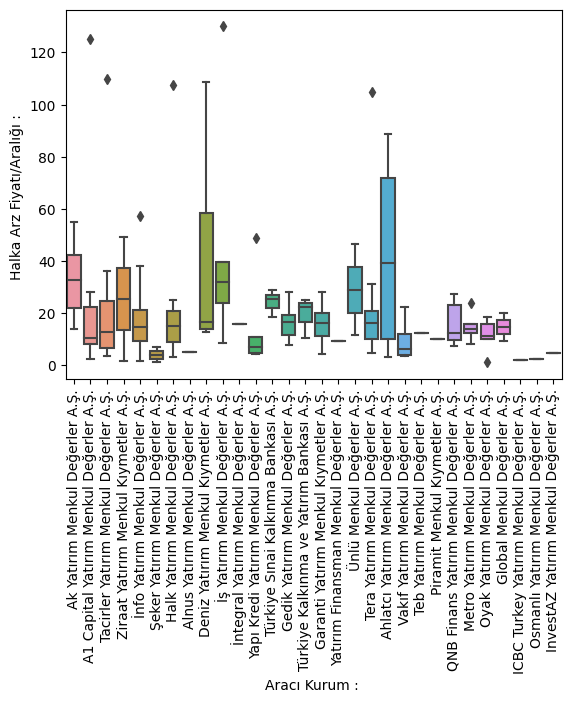

In [25]:
ax = sns.boxplot(x = info_df['Aracı Kurum : '], y =info_df['Halka Arz Fiyatı/Aralığı : ']);
ax.set_xticklabels(ax.get_xticklabels(),rotation=90);

In [27]:
Stocks_copy['EKSUN']['Halka_arz_result']['Yurtiçi Bireysel_Kisi']

0    1.209.314
Name: Yurtiçi Bireysel_Kisi, dtype: object

In [32]:
Stocks_copy['BIGCH']['Halka_arz_result']['Yurt İçi Bireysel_Kisi'].apply(value_fix_dot)

0    1800797.0
Name: Yurt İçi Bireysel_Kisi, dtype: float64

In [29]:
tesd_df = Stocks_copy['ADGYO']['Halka_arz_result']

In [30]:
tesd_df

,Yurt İçi Gerçek Kişi_Kisi,Yurt İçi Gerçek Kişi_Lot,Yurt İçi Kurumsal_Kisi,Yurt İçi Kurumsal_Lot,Yurt Dışı Gerçek Kişi_Kisi,Yurt Dışı Gerçek Kişi_Lot
0,2531660.0,73.566.342,396,12.382,4.248,121.276


In [48]:
with open('stocks.p', 'rb') as handle:
    Stocks_copy = pickle.load(handle)

In [21]:
test_cols = tesd_df.columns
test_cols

Index(['Yurt İçi Gerçek Kişi_Kisi', 'Yurt İçi Gerçek Kişi_Lot',
       'Yurt İçi Kurumsal_Kisi', 'Yurt İçi Kurumsal_Lot',
       'Yurt Dışı Gerçek Kişi_Kisi', 'Yurt Dışı Gerçek Kişi_Lot'],
      dtype='object')

In [20]:
'Yurt İçi Gerçek Kişi_Kisi' in test_cols

True

In [26]:
x, y = 4,4
if x == 3 and y == 4:
    print('1')
elif x == 3:
    print('2')
elif y == 4:
    print('3')

3


In [24]:
if ('Yurt Dışı Bireysel_Kisi' in test_cols) and ('Yurt İçi Gerçek Kişi_Kisi' in test_cols):
    print('y')
else:
    print('n')

n


In [28]:
halka_arz_result_df = pd.DataFrame()
for symbol in Stocks_copy:
    print(symbol)
    cols = Stocks_copy[symbol]['Halka_arz_result'].columns
    if ('Yurt İçi Bireysel_Kisi' in cols) and ('Yurt İçi Gerçek Kişi_Kisi' in cols):
        Stocks_copy[symbol]['Halka_arz_result']['Yurt İçi Bireysel_Kisi'] = Stocks_copy[symbol]['Halka_arz_result']['Yurt İçi Bireysel_Kisi'].apply(value_fix_dot)
        Stocks_copy[symbol]['Halka_arz_result']['Yurt İçi Gerçek Kişi_Kisi'] = Stocks_copy[symbol]['Halka_arz_result']['Yurt İçi Gerçek Kişi_Kisi'].apply(value_fix_dot)
    elif ('Yurt İçi Bireysel_Kisi' in cols):
        Stocks_copy[symbol]['Halka_arz_result']['Yurt İçi Bireysel_Kisi'] = Stocks_copy[symbol]['Halka_arz_result']['Yurt İçi Bireysel_Kisi'].apply(value_fix_dot)
    elif ('Yurt İçi Gerçek Kişi_Kisi' in cols):
        Stocks_copy[symbol]['Halka_arz_result']['Yurt İçi Gerçek Kişi_Kisi'] = Stocks_copy[symbol]['Halka_arz_result']['Yurt İçi Gerçek Kişi_Kisi'].apply(value_fix_dot)


AVPGY
MEGMT
KBORU
SURGY
CATES
SKYMD
BEGYO
AGROT
EKOS
BINHO
MARBL
TABGD
VRGYO
MHRGY
BORLS
DOFER
MEKAG
DMRGD
ADGYO
HATSN
REEDR
GIPTA
TARKM
EBEBK
KZGYO
BYDNR
ENERY
TATEN
OFSYM
IZENR
ASGYO
KLSER
FZLGY
ATAKP
FORTE
A1CAP
PASEU
KTLEV
BIENY
KAYSE
BIGCH
CWENE
GRTRK
EUPWR
CVKMD
KOPOL
EKSUN
AKFYE
GOKNR
BVSAN
MACKO
ASTOR
TNZTP
SOKE
SDTTR
ONCSM
EYGYO
TERA
AHGAZ
BRKVY
PLTUR
OZSUB
SNICA
ALFAS
AZTEK
HKTM
BARMA
OBASE
KRPLS
KLRHO
RUBNS
KCAER
PRDGS
MAKIM
EUREN
SEGYO
SUNTK
YYLGD
BMSTL
IMASM
KMPUR
CONSE
SUWEN
LIDER
SMRTG
ENSRI
GRSEL
GZNMI
KLSYN
HTTBT
INVES
DAPGM
HUNER
PNLSN
ERCB
PSGYO
RNPOL
PCILT
GMTAS
KONKA
MOBTL
MIATK
ISSEN
ELITE
ARASE
ULUFA
IHAAS
ANGEN
HEDEF
GLCVY
MAGEN
KIMMR
TEZOL
YEOTK
ORCAY
EGEPO
BRLSM
GESAN
KZBGY
GENIL
MANAS
KARYE
ESCAR
VBTYZ
KTSKR
EDATA
MEDTR
SELVA
BASGZ
OYYAT
BMSCH
UNLU
BOBET
ATATP
MERCN
KLKIM
PENTA
ZRGYO
CANTE
AYDEM
BIOEN
GWIND
TUREX
QUAGR
MTRKS
NTGAZ
TRILC
ISKPL


In [41]:
halka_arz_result_df = pd.DataFrame()
for symbol in Stocks_copy:
    print(symbol)
    Stocks_copy[symbol]['Halka_arz_result']['Yurt İçi Bireysel_Kisi'] = Stocks_copy[symbol]['Halka_arz_result']['Yurt İçi Bireysel_Kisi'].apply(value_fix_dot)
    halka_arz_result_df = pd.concat([halka_arz_result_df, Stocks_copy[symbol]['Halka_arz_result']], axis=0, join='outer')
halka_arz_result_df.head(50)

AVPGY
MEGMT
KBORU
SURGY
CATES
SKYMD
BEGYO
AGROT
EKOS
BINHO
MARBL
TABGD
VRGYO
MHRGY
BORLS
DOFER
MEKAG
DMRGD
ADGYO


KeyError: 'Yurt İçi Bireysel_Kisi'

In [42]:
Stocks_copy['AVPGY']['Halka_arz_result'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Yurt İçi Bireysel_Kisi  1 non-null      object
 1   Yurt İçi Bireysel_Lot   1 non-null      object
 2   Grup Çalışanları_Kisi   1 non-null      object
 3   Grup Çalışanları_Lot    1 non-null      object
 4   Yurt İçi Kurumsal_Kisi  1 non-null      object
 5   Yurt İçi Kurumsal_Lot   1 non-null      object
dtypes: object(6)
memory usage: 176.0+ bytes


In [14]:
with open('stocks.p', 'rb') as handle:
    Stocks_copy = pickle.load(handle)

In [52]:
cols = Stocks_copy['AVPGY']['Halka_arz_result'].columns
for col in cols:
    print(col)
    Stocks_copy['AVPGY']['Halka_arz_result'][col] = Stocks_copy['AVPGY']['Halka_arz_result'][col].apply(value_fix_dot)

Yurt İçi Bireysel_Kisi
Yurt İçi Bireysel_Lot
Grup Çalışanları_Kisi
Grup Çalışanları_Lot
Yurt İçi Kurumsal_Kisi
Yurt İçi Kurumsal_Lot


In [15]:
halka_arz_result_df = pd.DataFrame()
for symbol in Stocks_copy:
    for col in Stocks_copy[symbol]['Halka_arz_result'].columns:
        Stocks_copy[symbol]['Halka_arz_result'][col] = Stocks_copy[symbol]['Halka_arz_result'][col].apply(value_fix_dot)
    Stocks_copy[symbol]['Halka_arz_result']['Symbol'] = str(symbol)
    if Stocks_copy[symbol]['Hist_data'].shape[0] == 0:
        continue
    Stocks_copy[symbol]['Halka_arz_result']['Hype_Days'] = get_hyped_days(Stocks_copy[symbol]['Hist_data'])
    halka_arz_result_df = pd.concat([halka_arz_result_df, Stocks_copy[symbol]['Halka_arz_result']], axis=0, join='outer')
halka_arz_result_df.head(50)

,Yurt İçi Bireysel_Kisi,Yurt İçi Bireysel_Lot,Yurt İçi Kurumsal_Kisi,Yurt İçi Kurumsal_Lot,Şirket Çalışanları_Kisi,Şirket Çalışanları_Lot,Symbol,Hype_Days,Yurt Dışı Bireysel_Kisi,Yurt Dışı Bireysel_Lot,...,Yüksek Başvurulu Bireysel_Kisi,Yüksek Başvurulu Bireysel_Lot,Yurtiçi Gerçek_Kisi,Yurtiçi Gerçek_Lot,Yurtiçi Tüzel_Kisi,Yurtiçi Tüzel_Lot,Yurtdışı Gerçek_Kisi,Yurtdışı Gerçek_Lot,Yurtdışı Tüzel_Kisi,Yurtdışı Tüzel_Lot
0,3868974.0,48970000.0,142.0,13250000.0,333.0,530000.0,MEGMT,1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,3449487.0,23953225.0,50.0,338.0,NaN,NaN,KBORU,0,6690.0,46430.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,3768928.0,36000000.0,145.0,9000000.0,NaN,NaN,SURGY,1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,3137365.0,23144550.0,130.0,6610000.0,2570.0,651450.0,CATES,4,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,2825163.0,52401528.0,28.0,459.0,NaN,NaN,SKYMD,6,5322.0,97994.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,3255029.0,203000000.0,132.0,58000000.0,NaN,NaN,BEGYO,3,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,3048095.0,210000000.0,131.0,90000000.0,NaN,NaN,AGROT,5,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,3282235.0,59882889.0,32.0,604.0,NaN,NaN,EKOS,12,6462.0,116488.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,3042950.0,9481495.0,37.0,111.0,NaN,NaN,BINHO,8,5942.0,18394.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,2810287.0,58860115.0,25.0,501.0,NaN,NaN,MARBL,6,5594.0,115765.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [29]:
halka_arz_result_df.head(50)

,Yurt İçi Bireysel_Kisi,Yurt İçi Bireysel_Lot,Yurt İçi Kurumsal_Kisi,Yurt İçi Kurumsal_Lot,Şirket Çalışanları_Kisi,Şirket Çalışanları_Lot,Symbol,Hype_Days,Yurt Dışı Bireysel_Kisi,Yurt Dışı Bireysel_Lot,...,Yüksek Başvurulu Bireysel_Kisi,Yüksek Başvurulu Bireysel_Lot,Yurtiçi Gerçek_Kisi,Yurtiçi Gerçek_Lot,Yurtiçi Tüzel_Kisi,Yurtiçi Tüzel_Lot,Yurtdışı Gerçek_Kisi,Yurtdışı Gerçek_Lot,Yurtdışı Tüzel_Kisi,Yurtdışı Tüzel_Lot
0,3868974.0,48970000.0,142.0,13250000.0,333.0,530000.0,MEGMT,1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,3449487.0,23953225.0,50.0,338.0,NaN,NaN,KBORU,0,6690.0,46430.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,3768928.0,36000000.0,145.0,9000000.0,NaN,NaN,SURGY,1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,3137365.0,23144550.0,130.0,6610000.0,2570.0,651450.0,CATES,4,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,2825163.0,52401528.0,28.0,459.0,NaN,NaN,SKYMD,6,5322.0,97994.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,3255029.0,203000000.0,132.0,58000000.0,NaN,NaN,BEGYO,3,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,3048095.0,210000000.0,131.0,90000000.0,NaN,NaN,AGROT,5,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,3282235.0,59882889.0,32.0,604.0,NaN,NaN,EKOS,12,6462.0,116488.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,3042950.0,9481495.0,37.0,111.0,NaN,NaN,BINHO,8,5942.0,18394.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,2810287.0,58860115.0,25.0,501.0,NaN,NaN,MARBL,6,5594.0,115765.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [57]:
halka_arz_result_df.fillna(0, inplace=True)
halka_arz_result_df.reset_index(inplace=True)

In [58]:
halka_arz_result_df

,index,Yurt İçi Bireysel_Kisi,Yurt İçi Bireysel_Lot,Yurt İçi Kurumsal_Kisi,Yurt İçi Kurumsal_Lot,Şirket Çalışanları_Kisi,Şirket Çalışanları_Lot,Symbol,Hype_Days,Yurt Dışı Bireysel_Kisi,...,Yüksek Başvurulu Bireysel_Kisi,Yüksek Başvurulu Bireysel_Lot,Yurtiçi Gerçek_Kisi,Yurtiçi Gerçek_Lot,Yurtiçi Tüzel_Kisi,Yurtiçi Tüzel_Lot,Yurtdışı Gerçek_Kisi,Yurtdışı Gerçek_Lot,Yurtdışı Tüzel_Kisi,Yurtdışı Tüzel_Lot
0,0,3868974.0,48970000.0,142.0,13250000.0,333.0,530000.0,MEGMT,1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,3449487.0,23953225.0,50.0,338.0,0.0,0.0,KBORU,0,6690.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,3768928.0,36000000.0,145.0,9000000.0,0.0,0.0,SURGY,1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,3137365.0,23144550.0,130.0,6610000.0,2570.0,651450.0,CATES,4,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,2825163.0,52401528.0,28.0,459.0,0.0,0.0,SKYMD,6,5322.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,0,0.0,0.0,0.0,0.0,0.0,0.0,QUAGR,6,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
140,0,0.0,0.0,0.0,0.0,0.0,0.0,MTRKS,7,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
141,0,0.0,0.0,0.0,0.0,0.0,0.0,NTGAZ,7,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
142,0,0.0,0.0,0.0,0.0,0.0,0.0,TRILC,20,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [72]:
df = pd.DataFrame()
df['Symbol'] = halka_arz_result_df['Symbol']
df['HypeDays'] = halka_arz_result_df['Hype_Days']
df['Yurtici_Kisi'] = halka_arz_result_df['Yurt İçi Bireysel_Kisi'] + halka_arz_result_df['Yurt İçi Gerçek Kişi_Kisi'] + halka_arz_result_df['Yurtiçi Bireysel_Kisi'] + halka_arz_result_df[ 'Yurtiçi Gerçek_Kisi']
df['Yurtici_Lot'] = halka_arz_result_df['Yurt İçi Bireysel_Lot'] + halka_arz_result_df['Yurt İçi Gerçek Kişi_Lot'] + halka_arz_result_df['Yurtiçi Bireysel_Lot'] + halka_arz_result_df[ 'Yurtiçi Gerçek_Lot']
df['Yurtdisi_Kisi'] = halka_arz_result_df['Yurt Dışı Bireysel_Kisi'] + halka_arz_result_df['Yurt Dışı Gerçek Kişi_Kisi'] + halka_arz_result_df['Yurtdışı Bireysel_Kisi'] + halka_arz_result_df[ 'Yurtdışı Gerçek_Kisi']
df['Yurtdisi_Lot'] = halka_arz_result_df['Yurt Dışı Bireysel_Lot'] + halka_arz_result_df['Yurt Dışı Gerçek Kişi_Lot'] + halka_arz_result_df['Yurtdışı Bireysel_Lot'] + halka_arz_result_df[ 'Yurtdışı Gerçek_Lot']
df['Yurtici_Kurumsal'] = halka_arz_result_df['Yurt İçi Kurumsal_Kisi']  + halka_arz_result_df['Yurtiçi Kurumsal_Kisi'] + halka_arz_result_df[ 'Yurtiçi Tüzel_Kisi']
df['Yurtici_Kurumsal_Lot'] = halka_arz_result_df['Yurt İçi Kurumsal_Lot']  + halka_arz_result_df['Yurtiçi Kurumsal_Lot'] + halka_arz_result_df[ 'Yurtiçi Tüzel_Lot']
df['Yurtdisi_Kurumsal'] = halka_arz_result_df['Yurt Dışı Kurumsal_Kisi']  + halka_arz_result_df['Yurtdışı Kurumsal_Kisi'] + halka_arz_result_df[ 'Yurtdışı Tüzel_Kisi']
df['Yurtdisi_Kurumsal_Lot'] = halka_arz_result_df['Yurt Dışı Kurumsal_Lot']  + halka_arz_result_df['Yurtdışı Kurumsal_Lot'] + halka_arz_result_df[ 'Yurtdışı Tüzel_Lot']
df['Sirket_Calisanlari_Kisi'] = halka_arz_result_df['Şirket Çalışanları_Kisi'] + halka_arz_result_df['Grup Çalışanları_Kisi'] + halka_arz_result_df['Şirket Çalışanları / Çiftçi Yatırımcı_Kisi'] + halka_arz_result_df['Kale Grubu Çalışanları_Kisi'] 
df['Sirket_Calisanlari_Lot'] = halka_arz_result_df['Şirket Çalışanları_Lot'] + halka_arz_result_df['Grup Çalışanları_Lot'] + halka_arz_result_df['Şirket Çalışanları / Çiftçi Yatırımcı_Lot'] + halka_arz_result_df['Kale Grubu Çalışanları_Lot'] 
df['Yuksek Başvurulu_Kisi'] = halka_arz_result_df['Yüksek Başvurulu_Kisi']
df['Yuksek Başvurulu_Lot'] = halka_arz_result_df['Yüksek Başvurulu_Lot']
df['Yuksek Başvurulu Bireysel_Kisi'] = halka_arz_result_df['Yüksek Başvurulu Bireysel_Kisi']
df['Yuksek Başvurulu Bireysel_Lot'] = halka_arz_result_df['Yüksek Başvurulu Bireysel_Lot']

df

,Symbol,HypeDays,Yurtici_Kisi,Yurtici_Lot,Yurtdisi_Kisi,Yurtdisi_Lot,Yurtici_Kurumsal,Yurtici_Kurumsal_Lot,Yurtdisi_Kurumsal,Yurtdisi_Kurumsal_Lot,Sirket_Calisanlari_Kisi,Sirket_Calisanlari_Lot,Yuksek Başvurulu_Kisi,Yuksek Başvurulu_Lot,Yuksek Başvurulu Bireysel_Kisi,Yuksek Başvurulu Bireysel_Lot
0,MEGMT,1,3868974.0,48970000.0,0.0,0.0,142.0,13250000.0,0.0,0.0,333.0,530000.0,0.0,0.0,0.0,0.0
1,KBORU,0,3449487.0,23953225.0,6690.0,46430.0,50.0,338.0,1.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0
2,SURGY,1,3768928.0,36000000.0,0.0,0.0,145.0,9000000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,CATES,4,3137365.0,23144550.0,0.0,0.0,130.0,6610000.0,6.0,2644000.0,2570.0,651450.0,0.0,0.0,0.0,0.0
4,SKYMD,6,2825163.0,52401528.0,5322.0,97994.0,28.0,459.0,1.0,19.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,QUAGR,6,845221.0,23967816.0,1020.0,28977.0,108.0,3091.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
140,MTRKS,7,689348.0,7419157.0,0.0,0.0,823.0,3091.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
141,NTGAZ,7,210010.0,20700000.0,0.0,0.0,224.0,10350000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
142,TRILC,20,122870.0,8207500.0,0.0,0.0,46.0,9592500.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [101]:
df['Total_Lot'] = df['Yurtici_Lot'] + df['Yurtdisi_Lot'] + df['Yurtici_Kurumsal_Lot'] + df['Yurtdisi_Kurumsal_Lot'] + df['Sirket_Calisanlari_Lot'] + df['Yuksek Başvurulu_Lot'] + df['Yuksek Başvurulu Bireysel_Lot']
df['Total_Kisi'] = df['Yurtici_Kisi'] + df['Yurtdisi_Kisi'] + df['Yurtici_Kurumsal'] + df['Yurtdisi_Kurumsal'] + df['Sirket_Calisanlari_Kisi'] + df['Yuksek Başvurulu_Kisi'] + df['Yuksek Başvurulu Bireysel_Kisi']
df['Kurumsal_Oran'] = (df['Yurtici_Kurumsal_Lot'] + df['Yurtdisi_Kurumsal_Lot'])/df['Total_Lot'] * 100
df['Bireysel_Oran'] = (df['Yurtici_Lot'] + df['Yurtdisi_Lot'])/df['Total_Lot'] * 100
df['Bireysel_Kisi_Oran'] = (df['Yurtici_Kisi'] + df['Yurtdisi_Kisi'])/df['Total_Kisi'] * 100
df['Kurumsal_Kisi_Oran'] = (df['Yurtici_Kurumsal'] + df['Yurtdisi_Kurumsal'])/df['Total_Kisi'] * 100
df

,Symbol,HypeDays,Yurtici_Kisi,Yurtici_Lot,Yurtdisi_Kisi,Yurtdisi_Lot,Yurtici_Kurumsal,Yurtici_Kurumsal_Lot,Yurtdisi_Kurumsal,Yurtdisi_Kurumsal_Lot,...,Yuksek Başvurulu_Kisi,Yuksek Başvurulu_Lot,Yuksek Başvurulu Bireysel_Kisi,Yuksek Başvurulu Bireysel_Lot,Total_Lot,Kurumsal_Oran,Bireysel_Oran,Total_Kisi,Bireysel_Kisi_Oran,Kurumsal_Kisi_Oran
0,MEGMT,1,3868974.0,48970000.0,0.0,0.0,142.0,13250000.0,0.0,0.0,...,0.0,0.0,0.0,0.0,62750000.0,21.115538,78.039841,3869449.0,99.987724,0.003670
1,KBORU,0,3449487.0,23953225.0,6690.0,46430.0,50.0,338.0,1.0,7.0,...,0.0,0.0,0.0,0.0,24000000.0,0.001437,99.998563,3456228.0,99.998524,0.001476
2,SURGY,1,3768928.0,36000000.0,0.0,0.0,145.0,9000000.0,0.0,0.0,...,0.0,0.0,0.0,0.0,45000000.0,20.000000,80.000000,3769073.0,99.996153,0.003847
3,CATES,4,3137365.0,23144550.0,0.0,0.0,130.0,6610000.0,6.0,2644000.0,...,0.0,0.0,0.0,0.0,33050000.0,28.000000,70.028896,3140071.0,99.913824,0.004331
4,SKYMD,6,2825163.0,52401528.0,5322.0,97994.0,28.0,459.0,1.0,19.0,...,0.0,0.0,0.0,0.0,52500000.0,0.000910,99.999090,2830514.0,99.998975,0.001025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,QUAGR,6,845221.0,23967816.0,1020.0,28977.0,108.0,3091.0,0.0,0.0,...,0.0,0.0,0.0,0.0,23999884.0,0.012879,99.987121,846349.0,99.987239,0.012761
140,MTRKS,7,689348.0,7419157.0,0.0,0.0,823.0,3091.0,0.0,0.0,...,0.0,0.0,0.0,0.0,7422248.0,0.041645,99.958355,690171.0,99.880754,0.119246
141,NTGAZ,7,210010.0,20700000.0,0.0,0.0,224.0,10350000.0,0.0,0.0,...,0.0,0.0,0.0,0.0,31050000.0,33.333333,66.666667,210234.0,99.893452,0.106548
142,TRILC,20,122870.0,8207500.0,0.0,0.0,46.0,9592500.0,0.0,0.0,...,0.0,0.0,0.0,0.0,17800000.0,53.890449,46.109551,122916.0,99.962576,0.037424


In [112]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 22 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Symbol                          144 non-null    object 
 1   HypeDays                        144 non-null    int64  
 2   Yurtici_Kisi                    144 non-null    float64
 3   Yurtici_Lot                     144 non-null    float64
 4   Yurtdisi_Kisi                   144 non-null    float64
 5   Yurtdisi_Lot                    144 non-null    float64
 6   Yurtici_Kurumsal                144 non-null    float64
 7   Yurtici_Kurumsal_Lot            144 non-null    float64
 8   Yurtdisi_Kurumsal               144 non-null    float64
 9   Yurtdisi_Kurumsal_Lot           144 non-null    float64
 10  Sirket_Calisanlari_Kisi         144 non-null    float64
 11  Sirket_Calisanlari_Lot          144 non-null    float64
 12  Yuksek Başvurulu_Kisi           144 

In [89]:
import seaborn as sns
import matplotlib.pyplot as plt


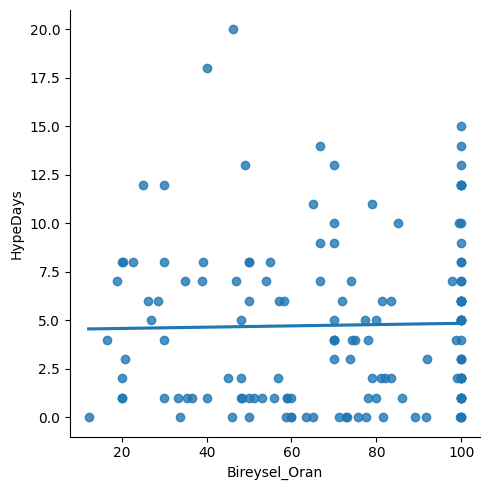

In [96]:
sns.lmplot(x='Bireysel_Oran', y='HypeDays', data=df, ci=None)
plt.show()

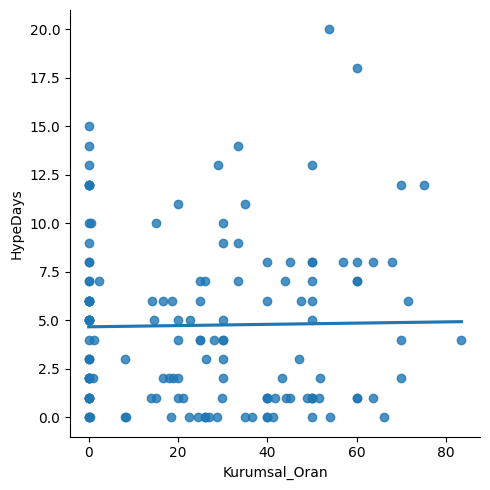

In [98]:
sns.lmplot(x='Kurumsal_Oran', y='HypeDays', data=df, ci=None)
plt.show()

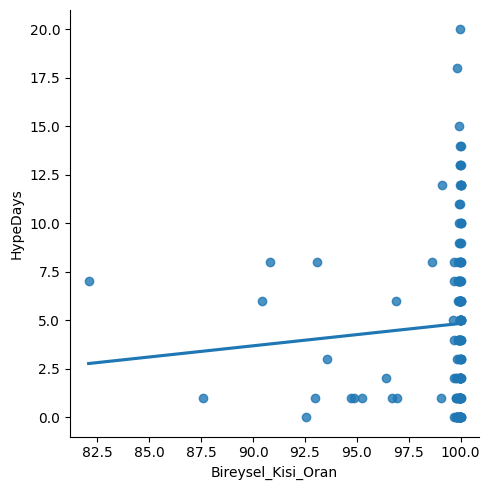

In [136]:
sns.lmplot(x='Bireysel_Kisi_Oran', y='HypeDays', data=df, ci=None)
plt.show()

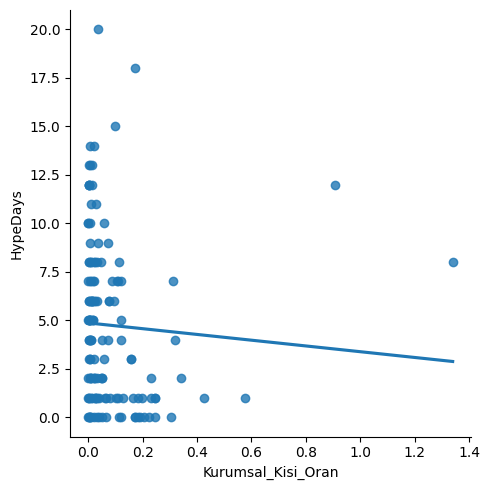

In [103]:
sns.lmplot(x='Kurumsal_Kisi_Oran', y='HypeDays', data=df, ci=None)
plt.show()

In [116]:
info_df.columns

Index(['Halka Arz Fiyatı/Aralığı : ', 'Dağıtım Yöntemi : ', 'Pay : ',
       'Aracı Kurum : ', 'Bist Kodu : ', 'Pazar : '],
      dtype='object')

In [122]:
info_df.set_index('Bist Kodu : ', inplace=True)

In [125]:
info_df.loc['AVPGY']['Halka Arz Fiyatı/Aralığı : ']

55.08

In [127]:
df_ = df.set_index('Symbol')
df_

,HypeDays,Yurtici_Kisi,Yurtici_Lot,Yurtdisi_Kisi,Yurtdisi_Lot,Yurtici_Kurumsal,Yurtici_Kurumsal_Lot,Yurtdisi_Kurumsal,Yurtdisi_Kurumsal_Lot,Sirket_Calisanlari_Kisi,...,Yuksek Başvurulu_Kisi,Yuksek Başvurulu_Lot,Yuksek Başvurulu Bireysel_Kisi,Yuksek Başvurulu Bireysel_Lot,Total_Lot,Kurumsal_Oran,Bireysel_Oran,Total_Kisi,Bireysel_Kisi_Oran,Kurumsal_Kisi_Oran
Symbol,,,,,,,,,,,,,,,,,,,,,
MEGMT,1,3868974.0,48970000.0,0.0,0.0,142.0,13250000.0,0.0,0.0,333.0,...,0.0,0.0,0.0,0.0,62750000.0,21.115538,78.039841,3869449.0,99.987724,0.003670
KBORU,0,3449487.0,23953225.0,6690.0,46430.0,50.0,338.0,1.0,7.0,0.0,...,0.0,0.0,0.0,0.0,24000000.0,0.001437,99.998563,3456228.0,99.998524,0.001476
SURGY,1,3768928.0,36000000.0,0.0,0.0,145.0,9000000.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,45000000.0,20.000000,80.000000,3769073.0,99.996153,0.003847
CATES,4,3137365.0,23144550.0,0.0,0.0,130.0,6610000.0,6.0,2644000.0,2570.0,...,0.0,0.0,0.0,0.0,33050000.0,28.000000,70.028896,3140071.0,99.913824,0.004331
SKYMD,6,2825163.0,52401528.0,5322.0,97994.0,28.0,459.0,1.0,19.0,0.0,...,0.0,0.0,0.0,0.0,52500000.0,0.000910,99.999090,2830514.0,99.998975,0.001025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
QUAGR,6,845221.0,23967816.0,1020.0,28977.0,108.0,3091.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,23999884.0,0.012879,99.987121,846349.0,99.987239,0.012761
MTRKS,7,689348.0,7419157.0,0.0,0.0,823.0,3091.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,7422248.0,0.041645,99.958355,690171.0,99.880754,0.119246
NTGAZ,7,210010.0,20700000.0,0.0,0.0,224.0,10350000.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,31050000.0,33.333333,66.666667,210234.0,99.893452,0.106548


In [130]:
idx = df_.index
df_['Halka Arz Fiyat'] = info_df.loc[idx]['Halka Arz Fiyatı/Aralığı : ']

In [131]:
df_

,HypeDays,Yurtici_Kisi,Yurtici_Lot,Yurtdisi_Kisi,Yurtdisi_Lot,Yurtici_Kurumsal,Yurtici_Kurumsal_Lot,Yurtdisi_Kurumsal,Yurtdisi_Kurumsal_Lot,Sirket_Calisanlari_Kisi,...,Yuksek Başvurulu_Lot,Yuksek Başvurulu Bireysel_Kisi,Yuksek Başvurulu Bireysel_Lot,Total_Lot,Kurumsal_Oran,Bireysel_Oran,Total_Kisi,Bireysel_Kisi_Oran,Kurumsal_Kisi_Oran,Halka Arz Fiyat
Symbol,,,,,,,,,,,,,,,,,,,,,
MEGMT,1,3868974.0,48970000.0,0.0,0.0,142.0,13250000.0,0.0,0.0,333.0,...,0.0,0.0,0.0,62750000.0,21.115538,78.039841,3869449.0,99.987724,0.003670,28.30
KBORU,0,3449487.0,23953225.0,6690.0,46430.0,50.0,338.0,1.0,7.0,0.0,...,0.0,0.0,0.0,24000000.0,0.001437,99.998563,3456228.0,99.998524,0.001476,36.20
SURGY,1,3768928.0,36000000.0,0.0,0.0,145.0,9000000.0,0.0,0.0,0.0,...,0.0,0.0,0.0,45000000.0,20.000000,80.000000,3769073.0,99.996153,0.003847,49.18
CATES,4,3137365.0,23144550.0,0.0,0.0,130.0,6610000.0,6.0,2644000.0,2570.0,...,0.0,0.0,0.0,33050000.0,28.000000,70.028896,3140071.0,99.913824,0.004331,57.15
SKYMD,6,2825163.0,52401528.0,5322.0,97994.0,28.0,459.0,1.0,19.0,0.0,...,0.0,0.0,0.0,52500000.0,0.000910,99.999090,2830514.0,99.998975,0.001025,7.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
QUAGR,6,845221.0,23967816.0,1020.0,28977.0,108.0,3091.0,0.0,0.0,0.0,...,0.0,0.0,0.0,23999884.0,0.012879,99.987121,846349.0,99.987239,0.012761,16.46
MTRKS,7,689348.0,7419157.0,0.0,0.0,823.0,3091.0,0.0,0.0,0.0,...,0.0,0.0,0.0,7422248.0,0.041645,99.958355,690171.0,99.880754,0.119246,28.00
NTGAZ,7,210010.0,20700000.0,0.0,0.0,224.0,10350000.0,0.0,0.0,0.0,...,0.0,0.0,0.0,31050000.0,33.333333,66.666667,210234.0,99.893452,0.106548,8.50


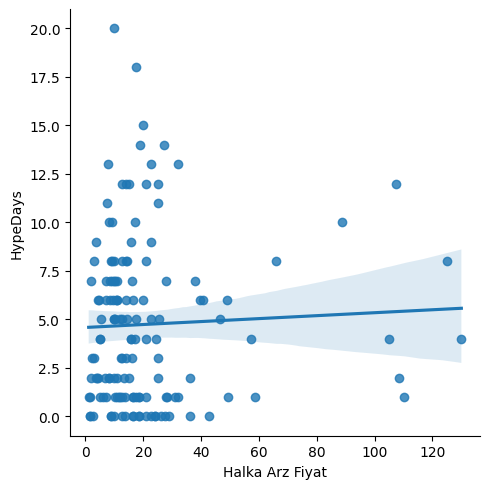

In [134]:
sns.lmplot(x='Halka Arz Fiyat', y='HypeDays', data=df_)
plt.show()